:

In [ ]:
# -----------------------------
# Core Libraries
# -----------------------------
import numpy as np
import pandas as pd

# -----------------------------
# Visualization Libraries
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Preprocessing
# -----------------------------
from sklearn.preprocessing import StandardScaler

# -----------------------------
# ML Models
# -----------------------------
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

# -----------------------------
# Model Evaluation
# -----------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    classification_report,
    confusion_matrix
)


In [ ]:
pd.set_option("display.max_columns", None)


In [ ]:
# Load synthetic telecom KPI dataset
df = pd.read_csv("/content/df.csv")

df.head()


,cell_id,throughput_mbps,drop_rate,latency_ms,packet_loss,rsrp_dbm,is_faulty
0,1000,43.708611,0.062858,42.101582,0.077523,-106.390665,0
1,1001,95.564288,1.272821,14.206998,0.797032,-78.410648,0
2,1002,75.879455,0.628712,18.081436,0.810953,-92.316167,0
3,1003,63.879264,1.017141,54.927709,0.956145,-81.073989,0
4,1004,24.041678,1.815133,40.321453,1.089137,-98.798264,0


# ML-Driven Self-Organizing Network (SON)
## Step 1: Problem Definition & Data Loading

### Problem Statement
Modern cellular networks generate large volumes of Key Performance Indicator (KPI) data.
Manually configuring, optimizing, and maintaining such networks is inefficient and error-prone.

This project demonstrates how basic Machine Learning (ML) models can support
Self-Organizing Network (SON) functions using telecom KPI data.

### SON Functions Covered
- Self-Configuration
- Self-Optimization
- Self-Healing

### Scope of This Step
- Define the problem
- Load telecom KPI dataset
- Perform basic inspection and sanity checks


In [ ]:
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns)


Dataset Shape: (100, 7)

Column Names:
Index(['cell_id', 'throughput_mbps', 'drop_rate', 'latency_ms', 'packet_loss',
       'rsrp_dbm', 'is_faulty'],
      dtype='object')


In [ ]:
df.describe()

,cell_id,throughput_mbps,drop_rate,latency_ms,packet_loss,rsrp_dbm,is_faulty
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000
mean,1049.500000,47.563305,1.457224,42.309952,0.956641,-94.505963,0.15000
std,29.011492,27.382703,1.261162,22.352340,0.631690,13.140569,0.35887
min,1000.000000,4.000868,0.013904,10.253079,0.021590,-129.641330,0.00000
25%,1024.750000,24.041135,0.502320,24.591460,0.528271,-106.408175,0.00000
50%,1049.500000,42.985263,1.266505,40.947443,0.959887,-94.089954,0.00000
75%,1074.250000,72.090020,1.786884,54.026557,1.257306,-82.346207,0.00000
max,1099.000000,98.819824,5.871115,105.783747,3.022348,-75.246232,1.00000


### KPI Description

- **throughput_mbps**: Average cell throughput (higher is better)
- **drop_rate**: Call drop percentage (lower is better)
- **latency_ms**: End-to-end delay (lower is better)
- **packet_loss**: Packet loss percentage (lower is better)
- **rsrp_dbm**: Signal strength indicator (closer to 0 is better)
- **is_faulty**: Ground truth label (1 = faulty cell, 0 = normal cell)

This dataset is synthetic but generated within realistic cellular network ranges.
Faulty cells are injected to simulate real network degradation.


In [ ]:
df["is_faulty"].value_counts()


,count
is_faulty,
0,85
1,15


### Initial Observations

- The dataset contains both normal and faulty cells
- Faulty cells typically exhibit:
  - Lower throughput
  - Higher drop rate
  - Higher latency
  - Poorer signal strength (RSRP)

These patterns motivate the use of ML models to:
- Detect faulty cells (Self-Healing)
- Group cells by performance (Self-Optimization)
- Estimate performance for configuration (Self-Configuration)


# Step 2: Exploratory Data Analysis (EDA)

### Objectives
- Analyze telecom KPI distributions
- Compare normal and faulty cells
- Identify patterns relevant to SON functions
- Build intuition before applying ML models

This step helps validate whether KPIs are meaningful for:
- Fault detection (Self-Healing)
- Performance grouping (Self-Optimization)
- Parameter estimation (Self-Configuration)


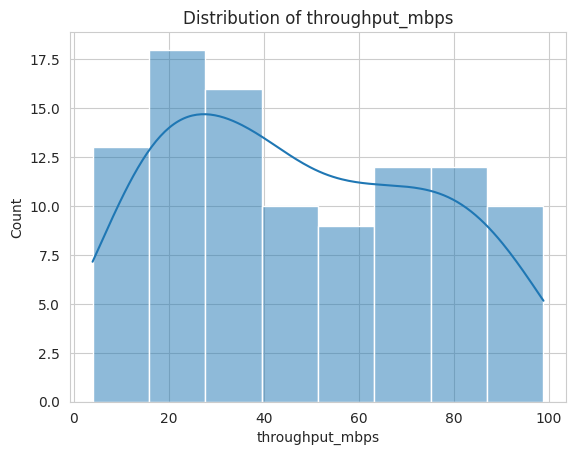

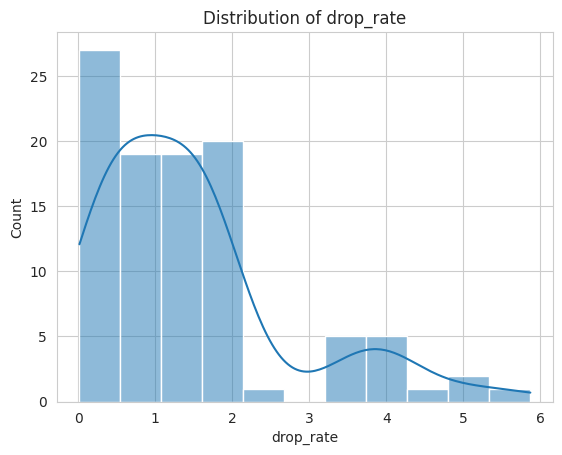

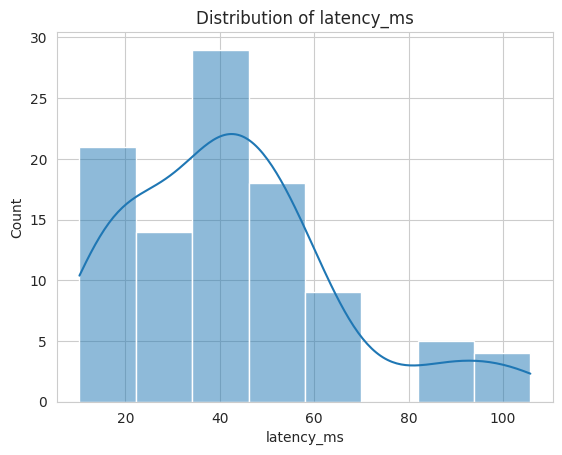

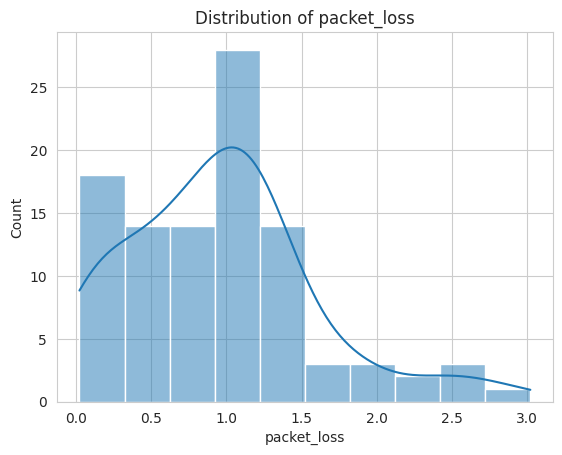

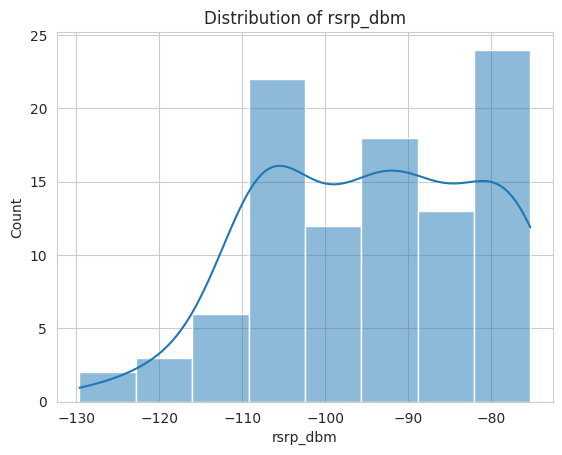

In [ ]:
kpis = ["throughput_mbps", "drop_rate", "latency_ms", "packet_loss", "rsrp_dbm"]

for kpi in kpis:
    plt.figure()
    sns.histplot(df[kpi], kde=True)
    plt.title(f"Distribution of {kpi}")
    plt.show()


In [ ]:
grouped_stats = df.groupby("is_faulty").mean()
grouped_stats


,cell_id,throughput_mbps,drop_rate,latency_ms,packet_loss,rsrp_dbm
is_faulty,,,,,,
0,1049.376471,52.635583,1.000591,35.304144,0.776974,-91.738387
1,1050.200000,18.820395,4.044808,82.009537,1.974753,-110.188889


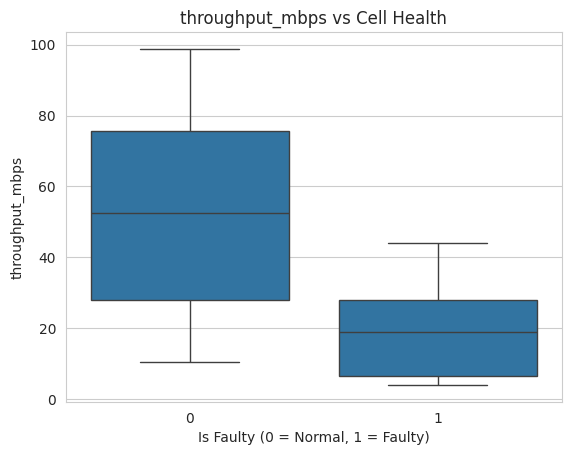

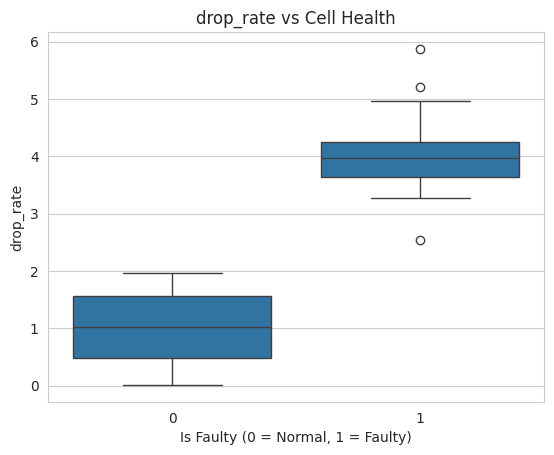

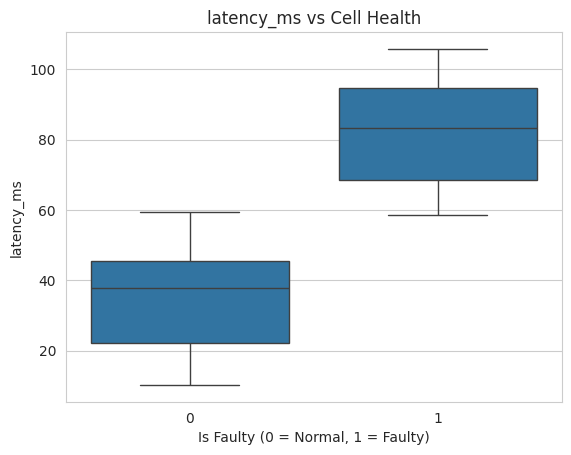

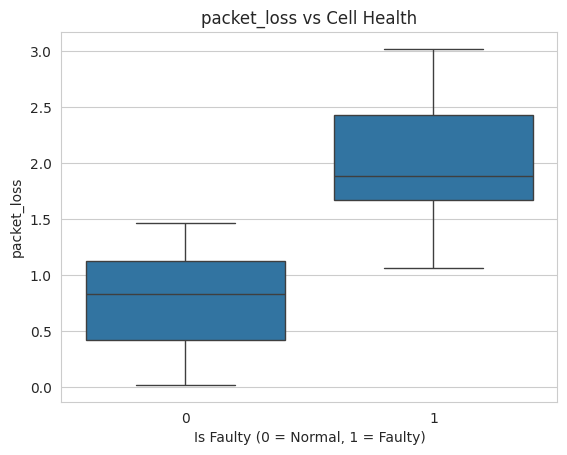

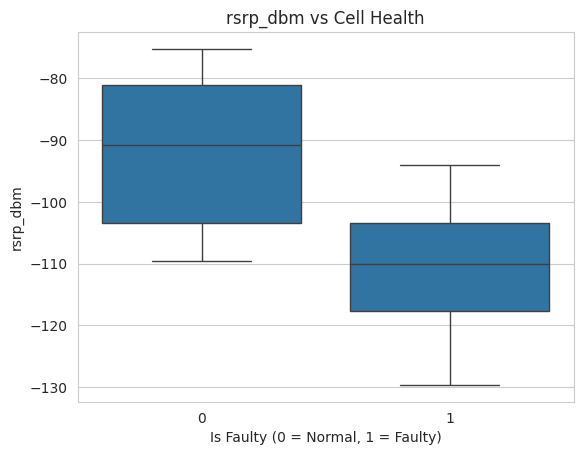

In [ ]:
for kpi in kpis:
    plt.figure()
    sns.boxplot(x="is_faulty", y=kpi, data=df)
    plt.title(f"{kpi} vs Cell Health")
    plt.xlabel("Is Faulty (0 = Normal, 1 = Faulty)")
    plt.show()


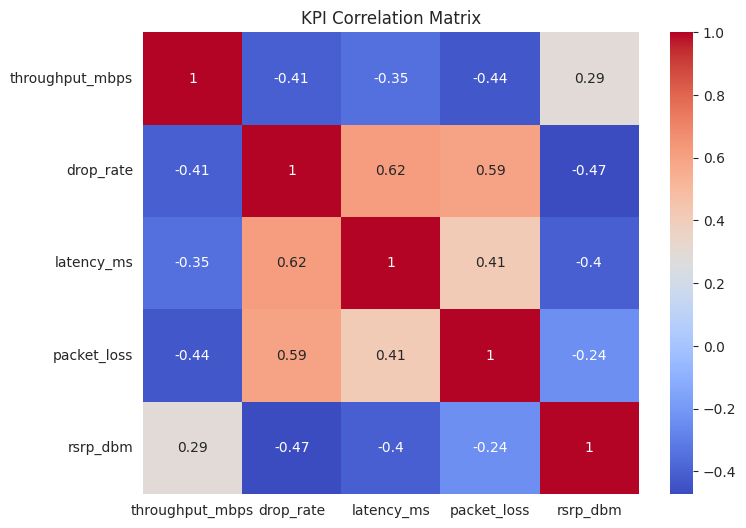

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[kpis].corr(), annot=True, cmap="coolwarm")
plt.title("KPI Correlation Matrix")
plt.show()


### Key Insights from EDA

- Faulty cells show:
  - Significantly lower throughput
  - Higher drop rate and latency
  - Poorer RSRP values
- Strong relationships exist between:
  - RSRP and throughput (the correlation seems a bit off due to fault injection in the dataset which causes non-linearity)
  - Latency and drop rate

These observations confirm:
- Anomaly detection is suitable for Self-Healing
- Clustering can group cells by performance
- Regression can estimate throughput from signal and delay


# Step 3: Self-Healing using Anomaly Detection

### Objective
The goal of self-healing in a Self-Organizing Network (SON) is to automatically
detect degraded or faulty network elements and trigger corrective actions. The scope of the problem prevents us from automating the optimization so we have stuck to basic classifying of the network in terms of if it needs attention or not .

In this step:
- We apply an unsupervised anomaly detection model
- Identify abnormal cells using KPI data
- Compare predictions with known faulty cells


In [ ]:
kpi_features = [
    "throughput_mbps",
    "drop_rate",
    "latency_ms",
    "packet_loss",
    "rsrp_dbm"
]

X = df[kpi_features]
y_true = df["is_faulty"]


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.15,
    random_state=42
)

df["anomaly_score"] = iso_forest.fit_predict(X_scaled)


In [ ]:
df["predicted_fault"] = df["anomaly_score"].apply(lambda x: 1 if x == -1 else 0)


In [ ]:
print(classification_report(y_true, df["predicted_fault"]))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98        85
           1       0.87      0.87      0.87        15

    accuracy                           0.96       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.96      0.96      0.96       100



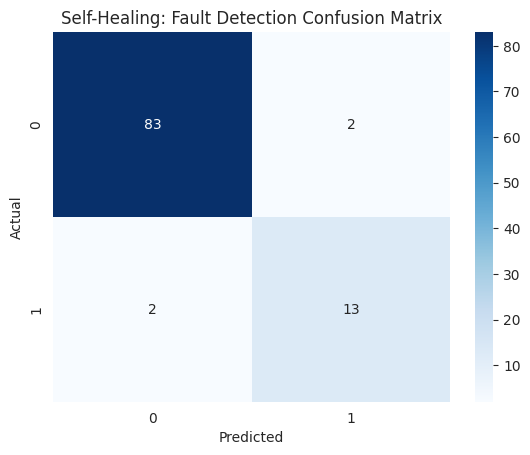

In [ ]:
cm = confusion_matrix(y_true, df["predicted_fault"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Self-Healing: Fault Detection Confusion Matrix")
plt.show()


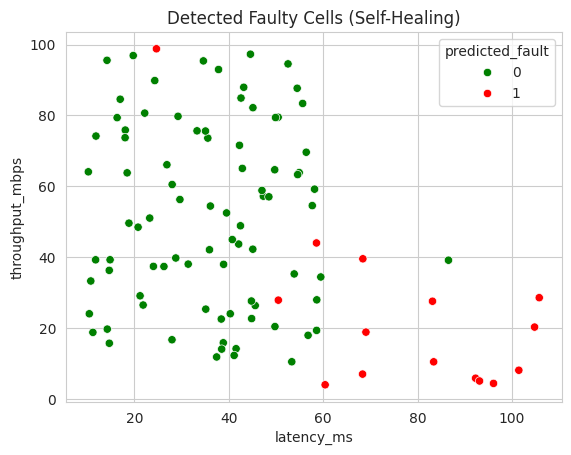

In [ ]:
plt.figure()
sns.scatterplot(
    data=df,
    x="latency_ms",
    y="throughput_mbps",
    hue="predicted_fault",
    palette={0: "green", 1: "red"}
)
plt.title("Detected Faulty Cells (Self-Healing)")
plt.show()


### Below code is a simple dashboard showing what to do when an anomaly occurs . This is a small automation done for show casing what the model does when anomalies are detected .


=== SELF-HEALING DECISION TABLE ===

    cell_id degradation_level                           healing_action
0      1000            Normal                       No action required
1      1001            Normal                       No action required
2      1002            Normal                       No action required
3      1003            Normal                       No action required
4      1004            Normal                       No action required
5      1005            Normal                       No action required
6      1006          Degraded     Warning raised, monitoring increased
7      1007            Normal                       No action required
8      1008            Normal                       No action required
9      1009            Normal                       No action required
10     1010            Normal                       No action required
11     1011            Normal                       No action required
12     1012            Normal          

/tmp/ipython-input-1038606983.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


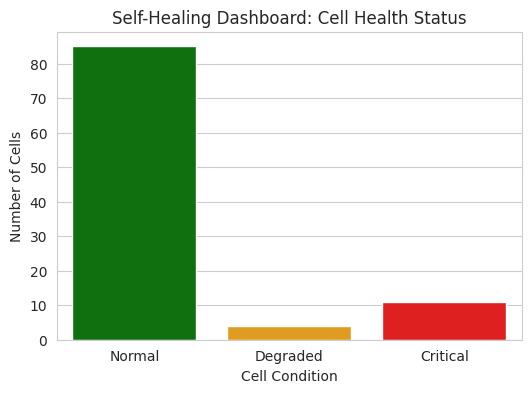

/tmp/ipython-input-1038606983.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


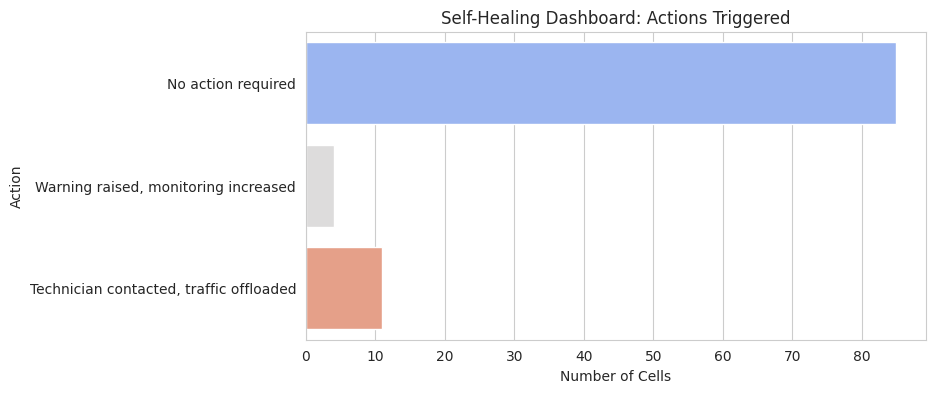

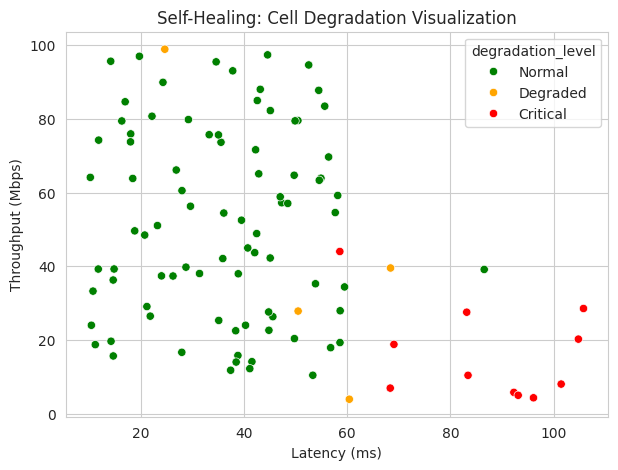

In [ ]:
"""
Self-Healing Dashboard for ML-Driven SON
---------------------------------------

This script visualizes:
- Faulty cell detection (Self-Healing)
- Degradation severity
- Triggered recovery actions

NOTE:
This is a visualization-only SON demonstration.
No real network automation is performed.
"""

# -----------------------------
# Imports
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Load Dataset
# -----------------------------
df = pd.read_csv("/content/df.csv")

# -----------------------------
# Select KPI Features
# -----------------------------
kpi_features = [
    "throughput_mbps",
    "drop_rate",
    "latency_ms",
    "packet_loss",
    "rsrp_dbm"
]

X = df[kpi_features]

# -----------------------------
# Scale Features
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# Anomaly Detection (Self-Healing Core)
# -----------------------------
iso_forest = IsolationForest(
    contamination=0.15,
    random_state=42
)

df["anomaly_score"] = iso_forest.fit_predict(X_scaled)

# Convert to fault flag
df["predicted_fault"] = df["anomaly_score"].apply(
    lambda x: 1 if x == -1 else 0
)

# -----------------------------
# Degradation Level Classification
# -----------------------------
def degradation_level(row):
    if row["predicted_fault"] == 0:
        return "Normal"

    if (
        row["latency_ms"] > 80 or
        row["drop_rate"] > 4 or
        row["packet_loss"] > 2
    ):
        return "Critical"
    else:
        return "Degraded"

df["degradation_level"] = df.apply(degradation_level, axis=1)

# -----------------------------
# Self-Healing Actions (Decision Layer)
# -----------------------------
def healing_action(level):
    if level == "Normal":
        return "No action required"
    elif level == "Degraded":
        return "Warning raised, monitoring increased"
    else:
        return "Technician contacted, traffic offloaded"

df["healing_action"] = df["degradation_level"].apply(healing_action)

# -----------------------------
# Print Decision Table (Core Output)
# -----------------------------
print("\n=== SELF-HEALING DECISION TABLE ===\n")
print(df[
    ["cell_id", "degradation_level", "healing_action"]
].head(60))

# -----------------------------
# DASHBOARD VISUALIZATIONS
# -----------------------------

sns.set_style("whitegrid")

# 1. Cell Health Status
plt.figure(figsize=(6,4))
sns.countplot(
    x="degradation_level",
    data=df,
    palette={
        "Normal": "green",
        "Degraded": "orange",
        "Critical": "red"
    }
)
plt.title("Self-Healing Dashboard: Cell Health Status")
plt.xlabel("Cell Condition")
plt.ylabel("Number of Cells")
plt.show()

# 2. Healing Actions Triggered
plt.figure(figsize=(8,4))
sns.countplot(
    y="healing_action",
    data=df,
    palette="coolwarm"
)
plt.title("Self-Healing Dashboard: Actions Triggered")
plt.xlabel("Number of Cells")
plt.ylabel("Action")
plt.show()

# 3. Faulty Cells in KPI Space
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df,
    x="latency_ms",
    y="throughput_mbps",
    hue="degradation_level",
    palette={
        "Normal": "green",
        "Degraded": "orange",
        "Critical": "red"
    }
)
plt.title("Self-Healing: Cell Degradation Visualization")
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (Mbps)")
plt.show()


### SON Mapping: Self-Healing

- **ML Task:** Anomaly Detection
- **Model Used:** Isolation Forest
- **Input:** Cell-level KPIs
- **Output:** Faulty / Normal cell classification

### ML-Driven Network Action
Cells detected as faulty can trigger:
- Alarm generation
- Automated troubleshooting
- Temporary traffic offloading
- Increased monitoring frequency

This demonstrates how ML supports the Self-Healing function in SON.


# Step 4: Self-Optimization using Clustering

### Objective
Self-Optimization in a Self-Organizing Network (SON) aims to continuously
improve network performance by tuning parameters such as power, handover
thresholds, and load balancing.

In this step:
- Cells are grouped into performance-based clusters
- A 3-level clustering approach is used:
  - Low Performance
  - Medium Performance
  - High Performance
- Clustering output is mapped to SON self-optimization actions


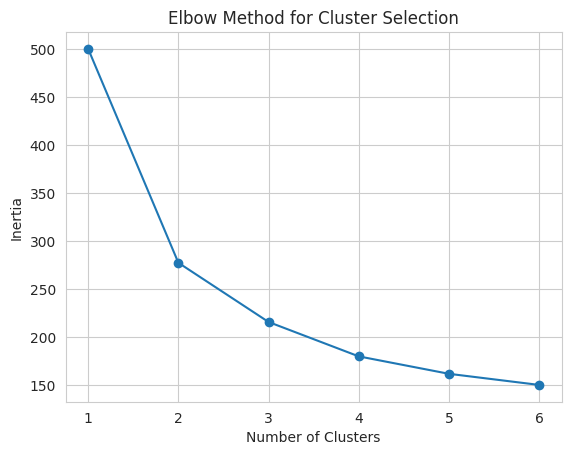

In [ ]:
inertia = []

for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, 7), inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Cluster Selection")
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
df["performance_cluster"] = kmeans.fit_predict(X_scaled)


In [ ]:
cluster_summary = df.groupby("performance_cluster")[kpi_features].mean()
cluster_summary


,throughput_mbps,drop_rate,latency_ms,packet_loss,rsrp_dbm
performance_cluster,,,,,
0,31.719150,1.067549,34.027722,0.901833,-93.013420
1,18.820395,4.044808,82.009537,1.974753,-110.188889
2,76.166569,0.925263,36.740118,0.636509,-90.303976


In [ ]:
# Sort clusters by throughput (low → high)
cluster_order = cluster_summary["throughput_mbps"].sort_values().index

cluster_labels = {
    cluster_order[0]: "Low Performance",
    cluster_order[1]: "Medium Performance",
    cluster_order[2]: "High Performance"
}

df["cluster_label"] = df["performance_cluster"].map(cluster_labels)


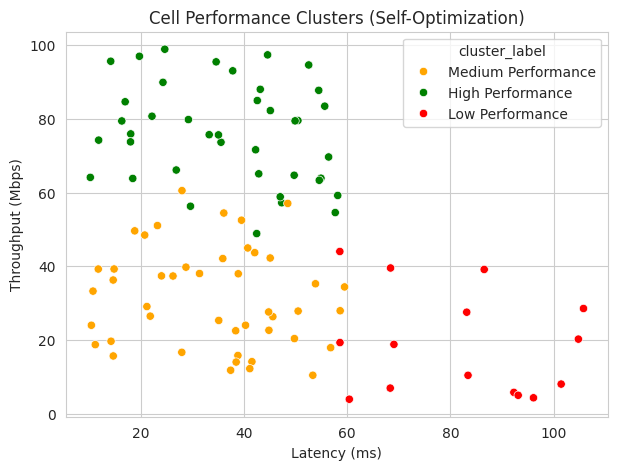

In [ ]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df,
    x="latency_ms",
    y="throughput_mbps",
    hue="cluster_label",
    palette={
        "Low Performance": "red",
        "Medium Performance": "orange",
        "High Performance": "green"
    }
)
plt.title("Cell Performance Clusters (Self-Optimization)")
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (Mbps)")
plt.show()


In [ ]:
pd.crosstab(df["cluster_label"], df["is_faulty"])


is_faulty,0,1
cluster_label,,
High Performance,40,0
Low Performance,0,15
Medium Performance,45,0


### SON Mapping: Self-Optimization

- **ML Task:** Clustering
- **Model Used:** K-Means
- **Input:** Cell-level KPIs
- **Output:** Performance-based cell groups

### ML-Driven Network Actions

**High Performance Cells**
- No optimization required
- Continuous monitoring

**Medium Performance Cells**
- Proactive optimization
- Fine-tune power and handover thresholds

**Low Performance Cells**
- Aggressive optimization
- Load balancing and parameter reconfiguration

This demonstrates how ML clustering enables data-driven self-optimization
in a Self-Organizing Network.


# Step 5: Self-Configuration using Flexible Regression

### Objective
Self-Configuration in a Self-Organizing Network (SON) focuses on automatically
setting initial configuration parameters for a newly deployed or reset cell.

In this step:
- Any 4 KPIs are used as inputs
- The 5th KPI is predicted as a reference value
- The predicted KPI acts as a baseline for initial configuration decisions

This approach enables flexible, data-driven self-configuration
without closed-loop optimization.


In [ ]:
KPI_LIST = [
    "throughput_mbps",
    "drop_rate",
    "latency_ms",
    "packet_loss",
    "rsrp_dbm"
]


In [ ]:
def train_self_configuration_model(df, target_kpi):
    """
    Train a regression model to predict `target_kpi`
    using the remaining KPIs as inputs.
    """

    if target_kpi not in KPI_LIST:
        raise ValueError("Target KPI must be one of the defined KPIs")

    input_kpis = [kpi for kpi in KPI_LIST if kpi != target_kpi]

    X = df[input_kpis]
    y = df[target_kpi]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    metrics = {
        "mse": mean_squared_error(y_test, y_pred),
        "r2": r2_score(y_test, y_pred)
    }

    return model, input_kpis, metrics


In [ ]:
tp_model, tp_inputs, tp_metrics = train_self_configuration_model(
    df, target_kpi="packet_loss"
)

tp_inputs, tp_metrics


(['throughput_mbps', 'drop_rate', 'latency_ms', 'rsrp_dbm'],
 {'mse': 0.3032870049152667, 'r2': 0.38106492951039184})

In [ ]:
lat_model, lat_inputs, lat_metrics = train_self_configuration_model(
    df, target_kpi="packet_loss"
)

lat_inputs, lat_metrics


(['throughput_mbps', 'drop_rate', 'latency_ms', 'rsrp_dbm'],
 {'mse': 0.3032870049152667, 'r2': 0.38106492951039184})

### This code can be used to develop models for different

In [ ]:
# New cell observed conditions (4 KPIs)
new_cell = pd.DataFrame([
    {
        "throughput_mbps": 42,
        "drop_rate": 1.1,
        "latency_ms": 42.3,  # Added a value for latency_ms, as it was a training feature
        "rsrp_dbm": -94
    }
])

# The model 'lat_model' was trained to predict 'packet_loss',
# so the prediction will be for packet_loss, not latency.
predicted_packet_loss = lat_model.predict(new_cell)[0]
predicted_packet_loss

np.float64(0.9247136852808704)

### SON Mapping: Self-Configuration

- **ML Task:** Regression
- **Model Used:** Linear Regression
- **Input:** RSRP, latency
- **Output:** Expected throughput

### ML-Driven Network Action
Based on predicted throughput:
- Set initial transmission power
- Allocate bandwidth resources
- Configure scheduling parameters

This enables automated and data-driven self-configuration of new cells.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(df["is_faulty"], df["predicted_fault"]))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98        85
           1       0.87      0.87      0.87        15

    accuracy                           0.96       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.96      0.96      0.96       100



In [ ]:
test_cell = pd.DataFrame({
    "throughput_mbps": [5],
    "drop_rate": [6],
    "latency_ms": [120],
    "packet_loss": [4],
    "rsrp_dbm": [-125]
})

test_cell_scaled = scaler.transform(test_cell)
iso_forest.predict(test_cell_scaled)


array([-1])

In [ ]:
test_cell = pd.DataFrame({
    "throughput_mbps": [70],
    "drop_rate": [0.5],
    "latency_ms": [20],
    "packet_loss": [0.2],
    "rsrp_dbm": [-85]
})

test_cell_scaled = scaler.transform(test_cell)
iso_forest.predict(test_cell_scaled)


array([1])

In [ ]:
df["cluster_label"].value_counts()


,count
cluster_label,
Medium Performance,45
High Performance,40
Low Performance,15


In [ ]:
df.groupby("cluster_label")[kpi_features].mean()


,throughput_mbps,drop_rate,latency_ms,packet_loss,rsrp_dbm
cluster_label,,,,,
High Performance,76.166569,0.925263,36.740118,0.636509,-90.303976
Low Performance,18.820395,4.044808,82.009537,1.974753,-110.188889
Medium Performance,31.719150,1.067549,34.027722,0.901833,-93.013420


In [ ]:
test_cells = pd.DataFrame({
    "rsrp_dbm": [-110, -95, -80],
    "latency_ms": [60, 40, 20]
})

# Define target and input KPIs based on the Self-Configuration description
target_kpi_for_reg = "throughput_mbps"
input_kpis_for_reg = ["rsrp_dbm", "latency_ms"]

# Prepare data for this specific regression model
X_reg = df[input_kpis_for_reg]
y_reg = df[target_kpi_for_reg]

# Train the new regression model on the full dataset for prediction purposes
reg_model = LinearRegression()
reg_model.fit(X_reg, y_reg)

# Make predictions using the newly trained reg_model
predicted_throughput = reg_model.predict(test_cells)
print(predicted_throughput)

[35.84818827 48.17299924 60.4978102 ]


In [ ]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

def send_critical_cells_email(df, sender_email, app_password):
    try:
        critical_cells = df[df["degradation_level"] == "Critical"]

        if critical_cells.empty:
            print("No critical cells. Email not sent.")
            return

        body = "SELF-HEALING ALERT: CRITICAL CELLS\n\n"

        for _, row in critical_cells.iterrows():
            body += (
                f"Cell ID: {row['cell_id']}\n"
                f"Latency: {row['latency_ms']} ms\n"
                f"Drop Rate: {row['drop_rate']} %\n"
                f"Packet Loss: {row['packet_loss']} %\n"
                f"Throughput: {row['throughput_mbps']} Mbps\n"
                f"RSRP: {row['rsrp_dbm']} dBm\n"
                f"Action: {row['healing_action']}\n"
                "-----------------------------\n"
            )

        msg = MIMEMultipart()
        msg["From"] = sender_email
        msg["To"] = sender_email
        msg["Subject"] = "SON ALERT: Critical Cells Detected"
        msg.attach(MIMEText(body, "plain"))

        with smtplib.SMTP("smtp.gmail.com", 587) as server:
            server.starttls()
            server.login(sender_email, app_password)
            server.send_message(msg)

        print("Email sent successfully.")

    except Exception as e:
        print("EMAIL FAILED")
        print(e)


In [ ]:
# @title
send_critical_cells_email(
    df=df,
    sender_email="ENTER YOUR EMAIL HERE",
    app_password="ENTER YOUR PASSKEY HERE"
)


Email sent successfully.
